# Progetto Laboratorio di Ottimizzazione, Intelligenza Artificiale e Machine Learning
A cura di Alessandro Cacchi 
- Email istituzionale: alessandro.cacchi@studio.unibo.it
- Matricola: 001080687

Sviluppo di una architettura di rete neurale volta a risolvere una classificazione multi-classe.


# Inclusione delle librerie necessarie

In [15]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
import yaml
from torchvision.models import alexnet
from collections import Counter



In [16]:
class CardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, yaml_file="archive/data.yaml"):
        """
        Args:
            images_dir (string): Percorso alla directory con le immagini.
            labels_dir (string): Percorso alla directory con le etichette.
            transform (callable, optional): Trasformazioni da applicare alle immagini.
            yaml_file (string): Percorso al file YAML contenente le classi.
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        try:
            with open(yaml_file, "r") as file:
                data = yaml.safe_load(file)
                self.classes = data.get("names", [])  # La lista di classi del file data.yaml
                print(f"Classi caricate: {self.classes}")
        except Exception as e:
            print(f"Errore nel caricamento del file YAML: {e}")
            self.classes = []

    def __len__(self):
        return len(os.listdir(self.images_dir))

    def __getitem__(self, idx):
        # Ottieni il nome dell'immagine e il percorso
        img_name = os.path.join(self.images_dir, os.listdir(self.images_dir)[idx])
        label_name = os.path.join(self.labels_dir, os.listdir(self.labels_dir)[idx].replace(".jpg", ".txt"))
        
        # Leggi le etichette dal file .txt
        with open(label_name, 'r') as file:
            label_info = file.readline().split()
        
        image = Image.open(img_name).convert("RGB")
        label = int(label_info[0])  # La prima colonna è l'etichetta numerica
        xmin, ymin, xmax, ymax = map(float, label_info[1:])

        # Normalizza il bounding box
        image_width, image_height = image.size
        bbox = torch.tensor([xmin / image_width, ymin / image_height, xmax / image_width, ymax / image_height], dtype=torch.float)

        if self.transform:
            image = self.transform(image)
        
        return image, bbox, label


In [17]:
def collate_fn(batch):
    # Filtra gli elementi None
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:  # Nessun elemento valido
        return None
    images, labels = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels)


# Definizione del dataset personalizzato

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adatta al tuo input
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=52)


# Trasformazioni per le immagini

In [19]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset e DataLoader

In [20]:
# Percorsi per le immagini e le etichette
train_images_dir = "archive/train/images"
train_labels_dir = "archive/train/labels"

# Trasformazioni per il dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Creazione del dataset e del dataloader
train_dataset = CardDataset(images_dir=train_images_dir, labels_dir=train_labels_dir, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test del DataLoader
for images, bboxes, labels in train_loader:
    print(f"Batch di immagini: {images.size()}")
    print(f"Bounding box: {bboxes}")
    print(f"Labels: {labels}")
    break

Classi caricate: ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
Batch di immagini: torch.Size([32, 3, 224, 224])
Bounding box: tensor([[9.8234e-04, 2.1640e-03, 2.3981e-04, 1.4735e-04],
        [2.0282e-03, 5.3451e-04, 2.4270e-04, 1.2424e-04],
        [6.9920e-04, 1.2568e-03, 2.4847e-04, 1.0979e-04],
        [1.1875e-03, 4.2761e-04, 1.1268e-04, 1.5313e-04],
        [1.1875e-03, 6.2696e-04, 1.4446e-04, 1.3002e-04],
        [1.2915e-03, 1.8780e-03, 9.2456e-05, 1.6469e-04],
        [1.4735e-03, 1.4013e-03, 1.5602e-04, 1.0112e-04],
        [1.3117e-03, 1.3175e-03, 1.5024e-04, 2.3403e-04],
        [4.3050e-04, 1.4071e-03, 1.5313e-04, 1.0401e-04],
        [1.0719e-03, 9.4189e-04, 2.3981e-04, 1.0401e-04],
        [1.2482e-03, 1.

In [21]:
# Percorsi per le immagini e le etichette del test
test_images_dir = "archive/test/images"
test_labels_dir = "archive/test/labels"

# Creazione del dataset di test
test_dataset = CardDataset(images_dir=test_images_dir, labels_dir=test_labels_dir, transform=train_transform)

# Creazione del DataLoader per il dataset di test
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Classi caricate: ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']


# Analisi del Dataset

In [22]:
def analyze_dataset(dataset):
    # Conta le occorrenze delle classi
    class_counts = Counter()
    for _, _, labels in dataset:
        # Se labels è un singolo intero, aggiornalo direttamente
        class_counts.update([labels])  # Converte l'intero in una lista con un elemento

    # Visualizza la distribuzione
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Classi")
    plt.ylabel("Numero di Occorrenze")
    plt.title("Distribuzione delle Classi nel Dataset")
    plt.xticks(classes, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return class_counts


_Analisi del dataset di addestramento_

Analisi del dataset di addestramento:


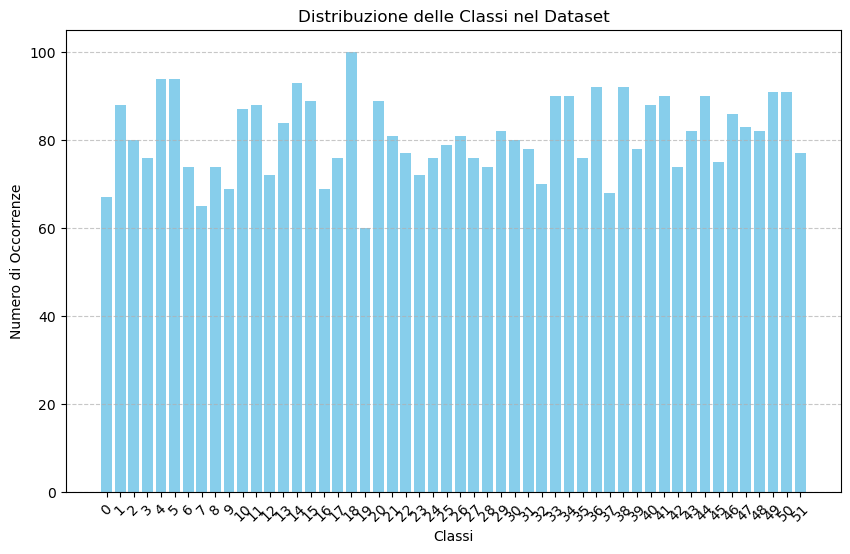

In [23]:
# Analisi del dataset di addestramento
print("Analisi del dataset di addestramento:")
train_class_counts = analyze_dataset(train_dataset)

_Analisi del dataset di test_

Analisi del dataset di test:


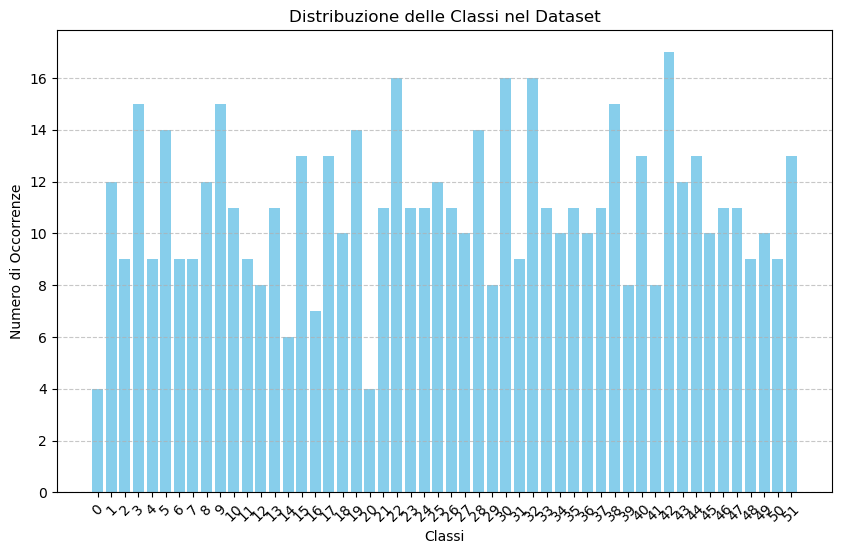

In [24]:
# Se desideri, analizza anche il dataset di test
print("Analisi del dataset di test:")
test_class_counts = analyze_dataset(test_dataset)

# Definizione del modello ResNet18 pre-addestrato

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 52)
model = model.to(device)

c:\Users\ale03\miniconda3\envs\corso_ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ale03\miniconda3\envs\corso_ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Definizione del modello AlexNet pre-addestrato

In [26]:
# Definizione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modello AlexNet pre-addestrato
model_alexnet = alexnet(pretrained=True)
num_features_alexnet = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_features_alexnet, 52)
model_alexnet = model_alexnet.to(device)  # definisco 'device'


c:\Users\ale03\miniconda3\envs\corso_ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Funzione di perdita e ottimizzatore

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Ciclo di addestramento

In [28]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    history = {"loss": [], "accuracy": []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, bboxes, labels in train_loader:
            label_indices = labels.to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, label_indices)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == label_indices).sum().item()
            total += label_indices.size(0)

        train_accuracy = 100 * correct / total
        history["loss"].append(running_loss / len(train_loader))
        history["accuracy"].append(train_accuracy)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")
    
    return history


# Addestramento dei modelli

_ResNet18_

In [29]:
# Addestramento ResNet18
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.parameters(), lr=0.0001)
history_resnet = train_model(model, train_loader, criterion, optimizer_resnet, epochs=5)


Epoch 1/5, Loss: 3.9466, Accuracy: 3.97%
Epoch 2/5, Loss: 3.0895, Accuracy: 27.99%
Epoch 3/5, Loss: 2.1757, Accuracy: 61.06%
Epoch 4/5, Loss: 1.2272, Accuracy: 89.62%
Epoch 5/5, Loss: 0.5133, Accuracy: 99.07%


_AlexNet_

In [30]:
# Addestramento AlexNet
optimizer_alexnet = optim.Adam(model_alexnet.parameters(), lr=0.0001)
history_alexnet = train_model(model_alexnet, train_loader, criterion, optimizer_alexnet, epochs=5)

Epoch 1/5, Loss: 3.9600, Accuracy: 2.26%
Epoch 2/5, Loss: 3.9012, Accuracy: 3.16%
Epoch 3/5, Loss: 3.8049, Accuracy: 4.97%
Epoch 4/5, Loss: 3.6173, Accuracy: 8.72%
Epoch 5/5, Loss: 3.2902, Accuracy: 14.73%


# Valutazione dei Modelli

In [31]:
def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, bboxes, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    accuracy = 100 * test_correct / test_total
    return accuracy


In [32]:
# Valutazione dei modelli
test_accuracy_resnet = evaluate_model(model, test_loader)
test_accuracy_alexnet = evaluate_model(model_alexnet, test_loader)

print(f"ResNet18 Test Accuracy: {test_accuracy_resnet:.2f}%")
print(f"AlexNet Test Accuracy: {test_accuracy_alexnet:.2f}%")


ResNet18 Test Accuracy: 12.96%
AlexNet Test Accuracy: 3.50%


# Visualizzazione dei risultati 

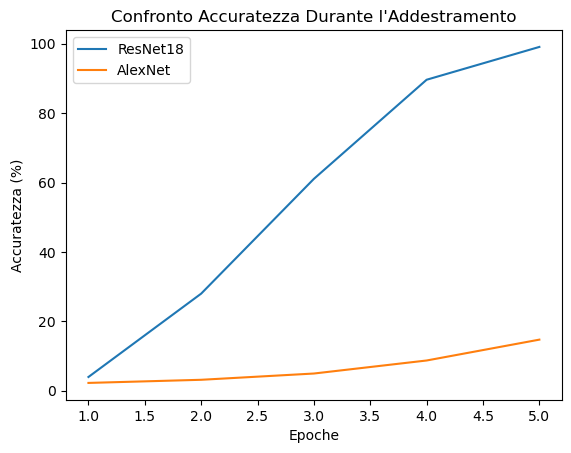

In [33]:
# Confronto delle metriche
epochs = range(1, 6)
plt.plot(epochs, history_resnet["accuracy"], label="ResNet18")
plt.plot(epochs, history_alexnet["accuracy"], label="AlexNet")
plt.title("Confronto Accuratezza Durante l'Addestramento")
plt.xlabel("Epoche")
plt.ylabel("Accuratezza (%)")
plt.legend()
plt.show()


Visualizzazione delle previsioni con ResNet18:


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 32, 3, 224, 224]

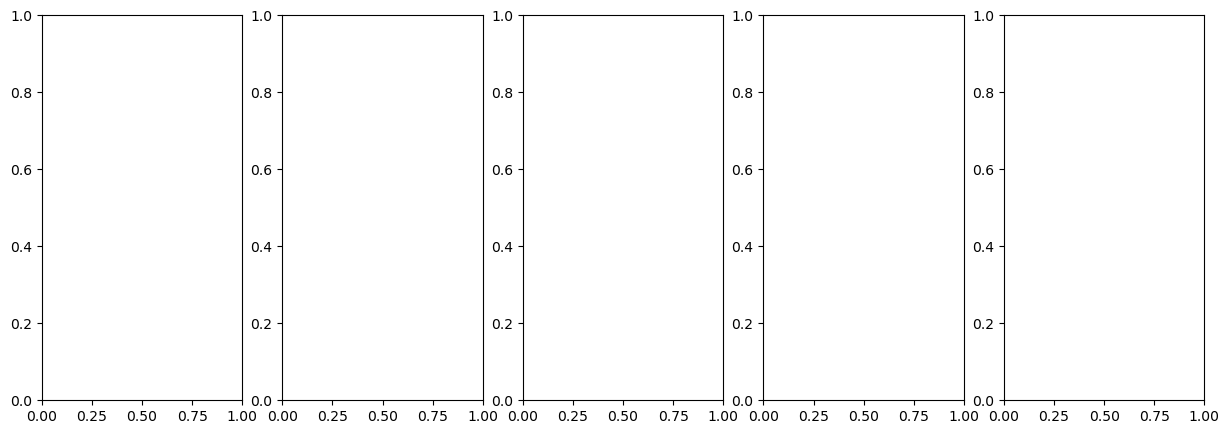

In [34]:
def visualize_predictions(model, dataset, num_images=5):
    model.eval()  # Mettiti in modalità di valutazione
    images_shown = 0
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    
    with torch.no_grad():
        for i, (images, bboxes, labels) in enumerate(dataset):
            if images_shown >= num_images:
                break
            
            # Portiamo immagini e modello sul dispositivo
            images = images.to(device).unsqueeze(0)  # Aggiungi la dimensione batch
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Torniamo ai valori originali per il display
            image = images.cpu().squeeze(0).permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalizza
            
            bbox = bboxes.cpu().numpy()
            predicted_label = preds.cpu().item()
            true_label = labels.item()
            
            # Visualizza l'immagine con il bounding box e l'etichetta
            axs[images_shown].imshow(image.numpy())
            axs[images_shown].set_title(f"Pred: {dataset.classes[predicted_label]}\nTrue: {dataset.classes[true_label]}")
            axs[images_shown].add_patch(plt.Rectangle(
                (bbox[0] * image.shape[1], bbox[1] * image.shape[0]),
                (bbox[2] - bbox[0]) * image.shape[1],
                (bbox[3] - bbox[1]) * image.shape[0],
                fill=False,
                edgecolor='red',
                linewidth=2
            ))
            axs[images_shown].axis('off')
            
            images_shown += 1
    plt.tight_layout()
    plt.show()

# Esegui la funzione per entrambi i modelli
print("Visualizzazione delle previsioni con ResNet18:")
visualize_predictions(model, test_loader, num_images=5)

print("Visualizzazione delle previsioni con AlexNet:")
visualize_predictions(model_alexnet, test_loader, num_images=5)


# Visualizzazione delle predizioni

In [ ]:
def show_predictions(dataloader, model, class_names, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalizza
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f"Predetto: {class_names[preds[i]]}, Reale: {class_names[labels[i]]}")
                plt.axis('off')
                plt.show()
                images_shown += 1


# Mostra alcune predizioni

In [ ]:
import os

def show_predictions(dataloader, model, class_names, output_dir="archive", num_images=10):
    model.eval()
    images_shown = 0

    # Creare la cartella per salvare le immagini, se non esiste
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                # Processa l'immagine
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalizza
                img = np.clip(img, 0, 1)

                # Nome file per salvare l'immagine
                filename = os.path.join(
                    output_dir,
                    f"predicted_{class_names[preds[i]]}_actual_{class_names[labels[i]]}_{images_shown}.png"
                )

                # Salva l'immagine
                plt.imsave(filename, img)
                print(f"Immagine salvata: {filename}")

                images_shown += 1
